# Escalonando Multiplas GPU's com CUDA C++

Neste repositório, será abordados os tópicos principais para uso de CUDA C++ para distribuição em multiplas GPU's. Para isso, será necessário o entendimento sobre o assunto de:
- __Streaming com uso de CUDA C++__
- Conhecimento sobre o funcionamento __CUDA C/C++__

# Explorando Concorrencia em Múltiplos dispositivos

Em uma implementação comum, temos as etapas de execução bem definidas, cuja soma do tempo de cada etapa resulta no tempo total de execução.
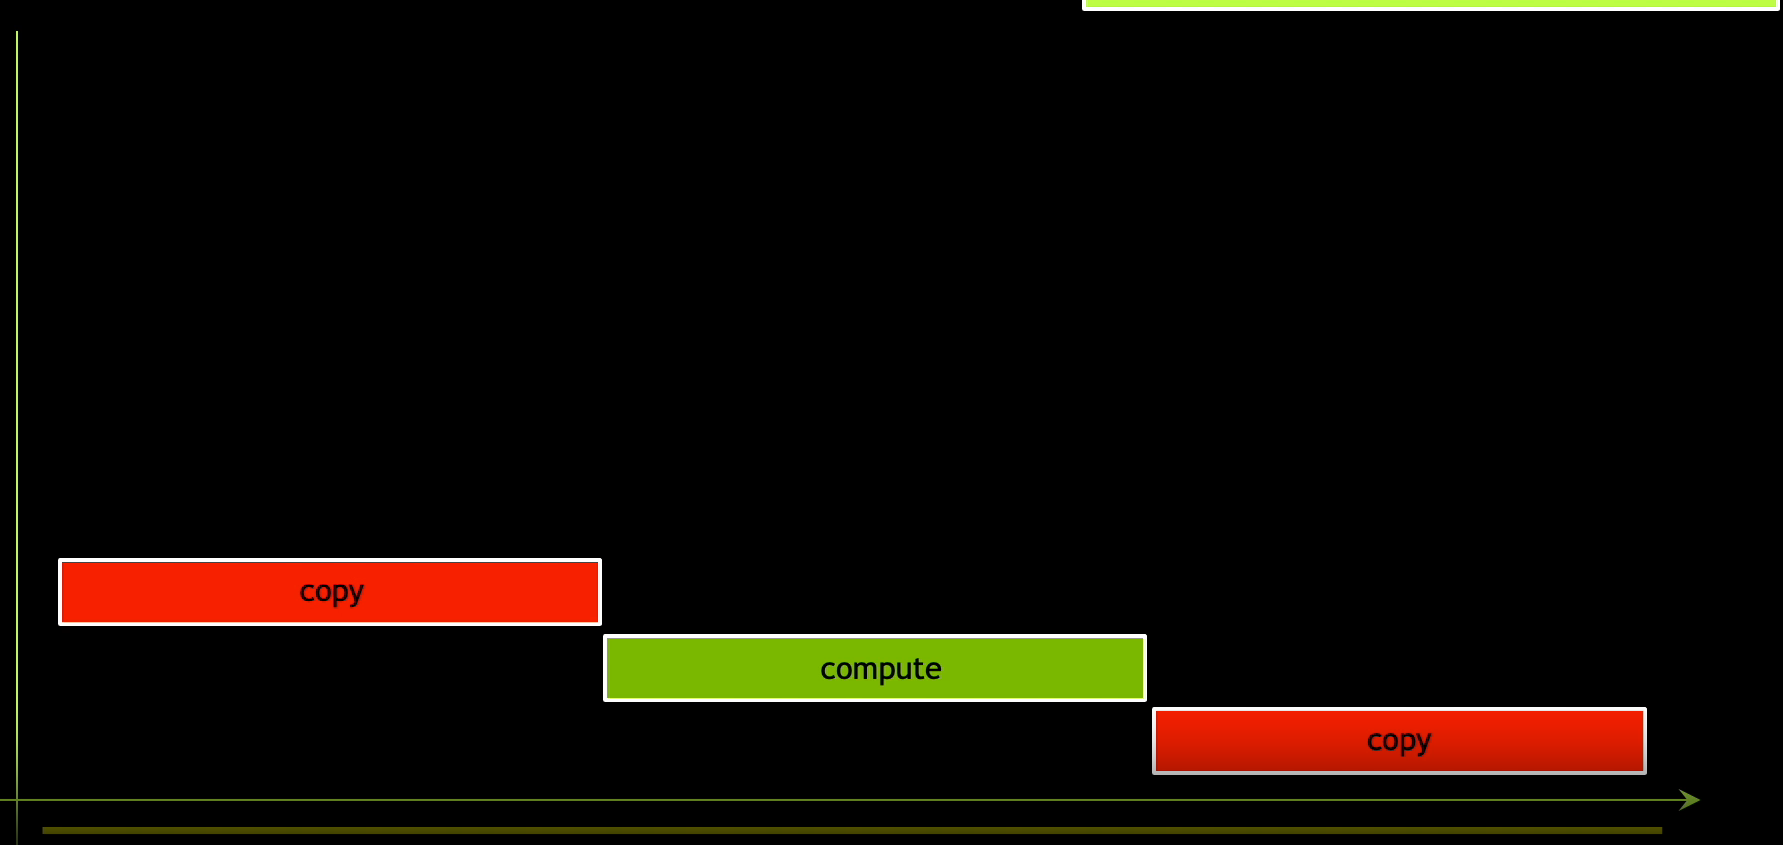


Mas se conseguimos sobrepor execuções, fragmentando em partes a execução de cada etapa, temos uma significante redução de tempo sobre o algoritmo:
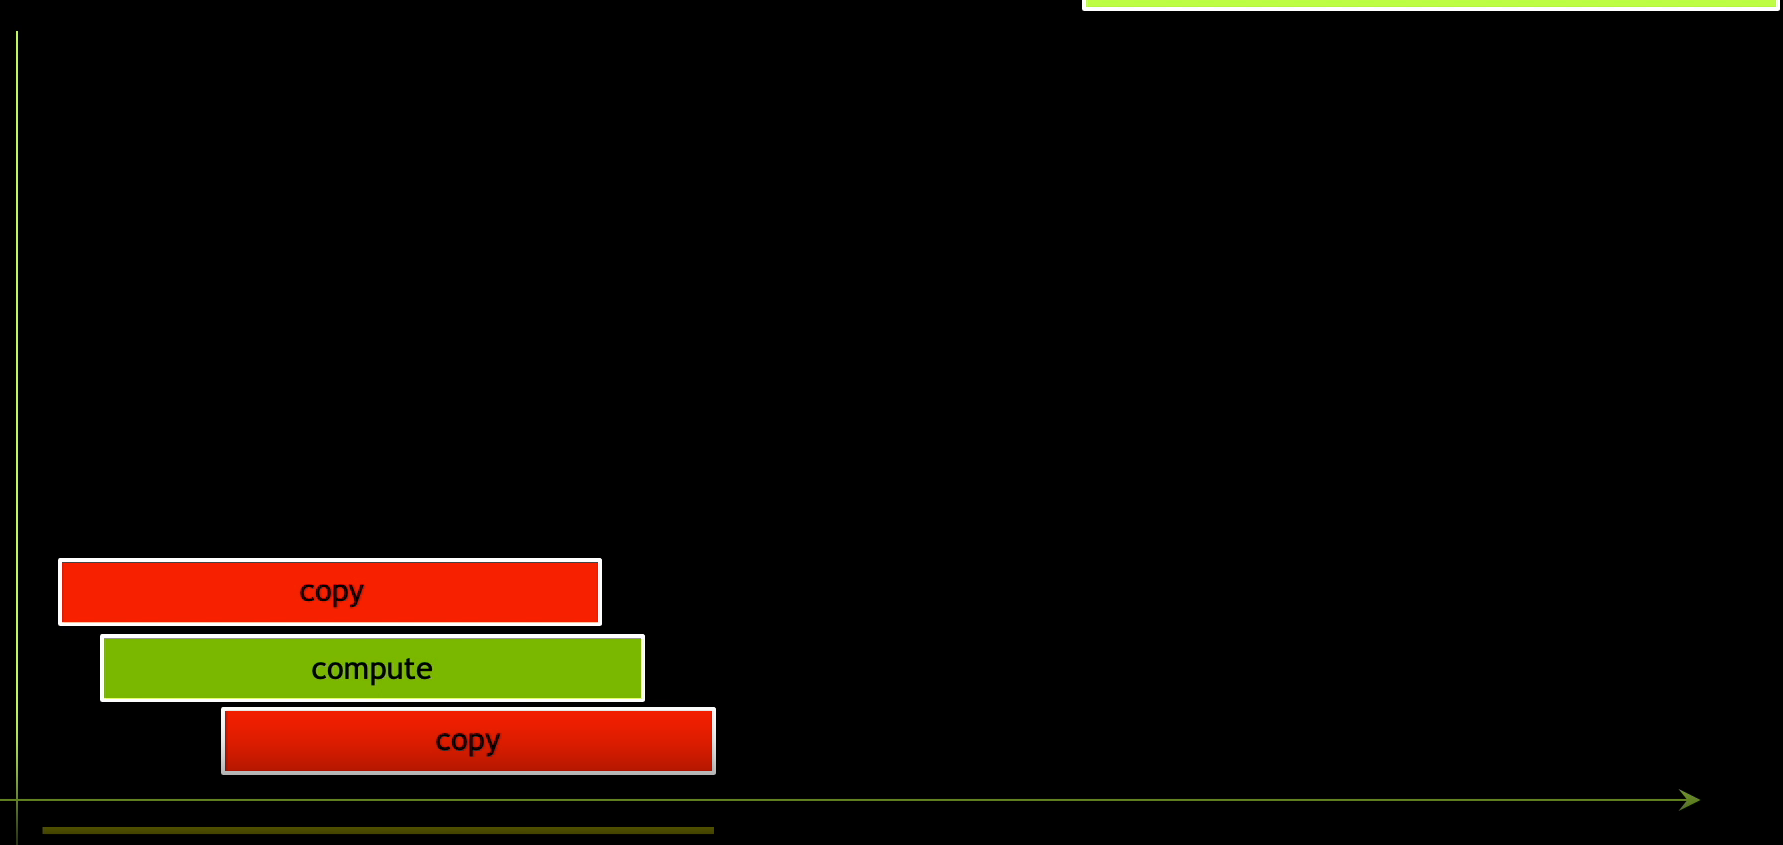


Uma estratégia adicional (que será abordada neste curso) será o uso de dispositivos adicionais no processamento de dados. Onde temos mais elementos de processamento para computação do algoritmo desejado:
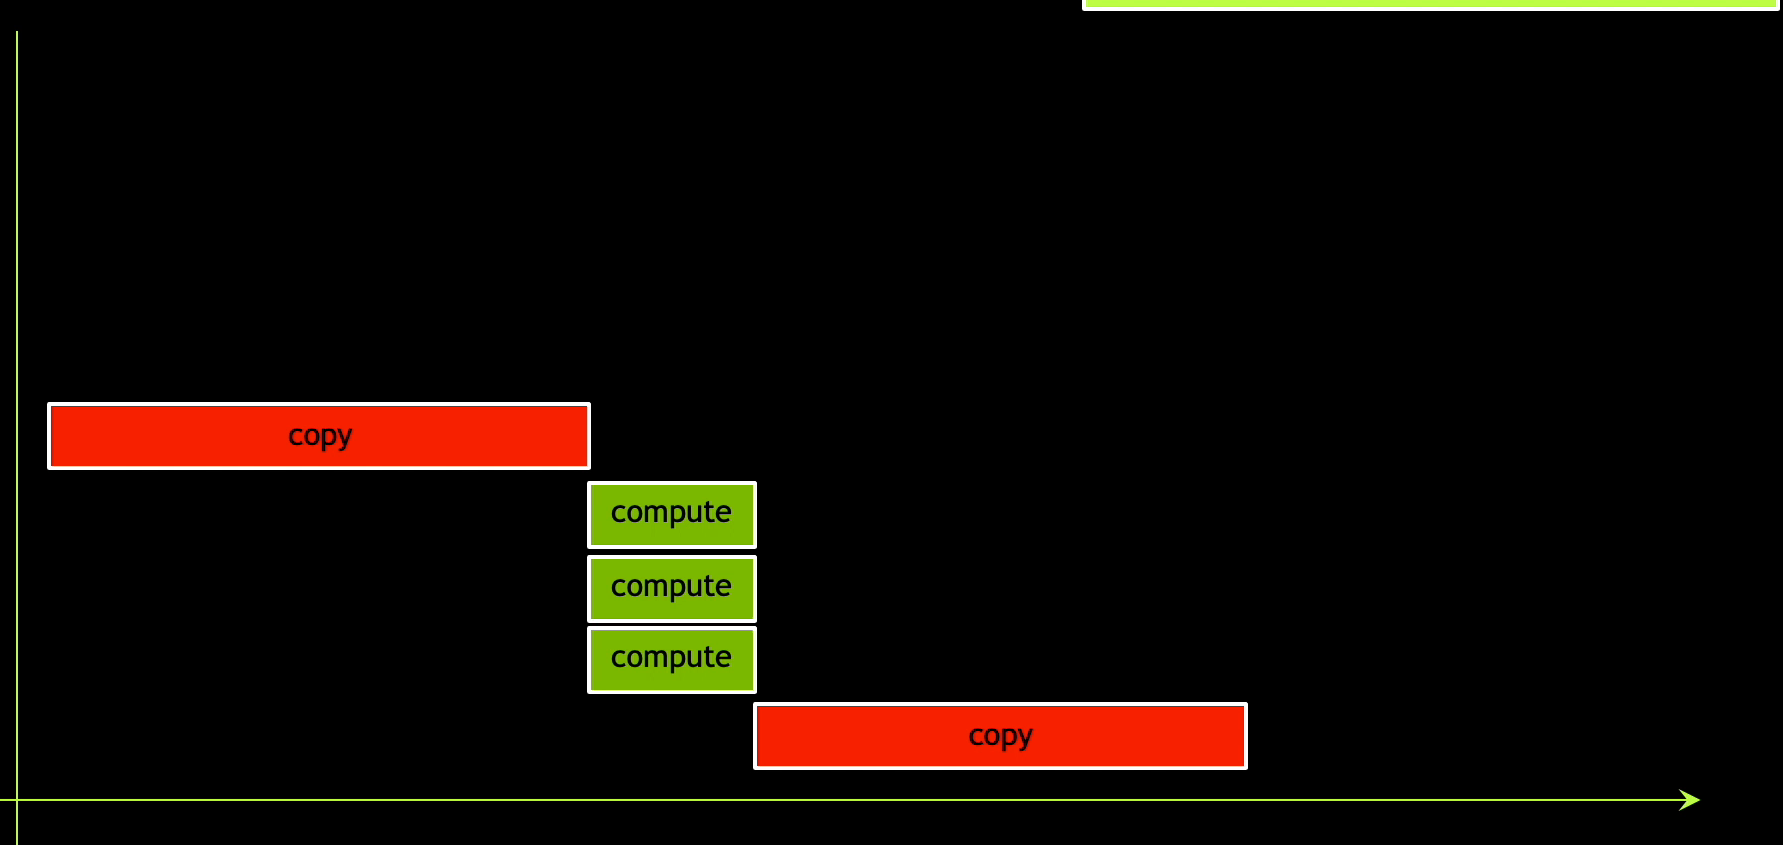


E mais ainda, é possivel associar a distribuição de dados por meio de sobreposição, bem como distribuição em mais de um dispositivo.
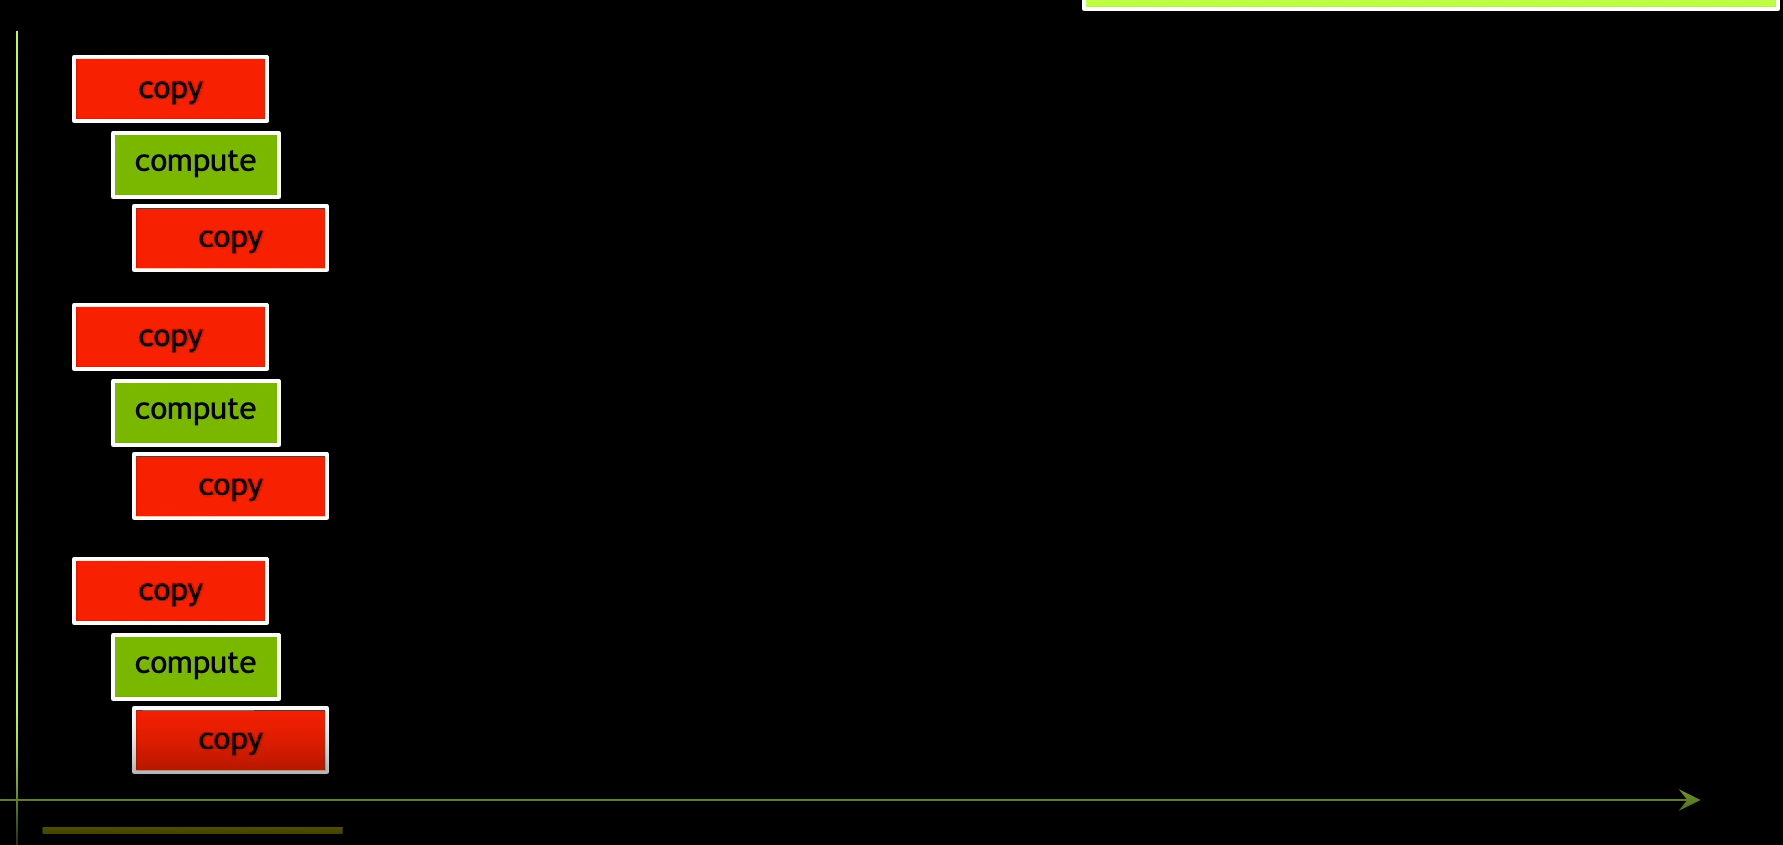

## Comandos Essenciais para Uso de Multiplas GPUS:

Obtenção do número de GPU's disponíveis para uso - `cudaGetDeviceCount`:
```cpp
    int num_gpus;
    cudaGetDeviceCount(&num_gpus);

```
Array contendo o número de cada GPU - `cudaGetDevice`:
```cpp
    int devices;
    cudaGetDeviceCount(&devices); 
    //retorna um array com indices de GPU's
```

Para cada thread de host, um device GPU é ativo de cada vez. Para definirmos uma GPU específica, devemos usar `cudaSetDevice` com o número desejado do índice. Por exemplo: 
```cpp
    cudaSetDevice(0);
```


## Iterando sobre as GPU's disponíveis
Um padrão comum é iterar sobre as GPU's, performando operações cada:
```cpp
    int num_gpus;
    cudaGetDeviceCount(&num_gpus);

    for(int gpu=0; gpu < num_gpus; gpu++){
        cudaSetDevice(0);
        //Executando operações para GPU-i
    }
```

# Como Lidar com a distribuição de Memória? 
Uma das estratégias utilizadas é por meio da definição de um ponteiro para multiplas GPU's. No exemplo abaixo, temos um exemplo de alocação com n-GPU's:
```cpp

const int num_gpus;
cudaGetDeviceCount(&num_gpus);

const uint64_t num_entries = 1UL << 26;
const uint64_t chunk_size = sdiv(num_entries, num_gpus);
uint64_t *datagpu[num_gpus];

for(int gpu=0; gpu<num_gpus; gpu++){
    const uint64_t lower = chunk_size*gpu;
    const uint64_t upper = min(lower+chunk_size, num_entries);
    const uint64_t width = upper - lower;
    cudaMalloc(&data_gpu[gpu], sizeof(uint64_t)*width);
}
```

# Lidando com a Cópia de Dados
Para cópia dos dados entre host-gpu, é feito o uso de `cudaMemcpy`. Para este caso, diferente como apresentado por meio de Streams, faz-se o uso apenas do index referenciado para o numero da GPU em conjunto com a chamada da função `cudaSetDevice`: 

```cpp
//Assumindo que os dados ja foram alocados, iteramos sobre o total de GPU
for(int gpu=0; gpu<num_gpus;gpu++){
    cudaSetDevice(gpu);
    //Definimos o tamanho dos dados a serem operados
    const uint64_t lower = chunk_size*gpu;
    const uint64_t upper = min(lower + chunk_size, num_entries);
    const uint64_t width = upper - lower;
    //Envio do kernel - chunk de dado para a gpu definida inicialmente
    kernel<<<grid, block>>>(data_gpu[gpu], width); 
}



```